# Predicting Sample Title Here

Learning Team 3
- Francis Mark Cayco
- Marianne Reyes
- Imee Lanie Uy
- Denver Valera

**COSCI 221 - Machine Learning 1** <br>
Master of Science in Data Science 2025

## Introduction
Text Here

## Highlights
1. First Highlight
2. Second Highlight
3. Third Highlight
4. Fourth Highlight
5. Fifth Highligh




In [1]:
# Install Dependencies.  Skip if already installed.
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import multiprocessing as mp
import re
import requests

import numpy as np
import pandas as pd
import scipy.sparse

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from langdetect import detect

from matplotlib import pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, ShuffleSplit, cross_validate,
                                     train_test_split)
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from tqdm import tqdm

nltk.download(['punkt_tab','wordnet'])

RANDOM_STATE = 420
np.random.seed(RANDOM_STATE)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/francismarkcayco/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/francismarkcayco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<div class="alert alert-info">

## Preprocessing and Feature Extraction
</div>

In [3]:
df = pd.read_csv('dataset.csv')
df.head(10)

,job_no,job_description,job_type,category
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
4,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations
5,Id-28415,"Mein Kunde, ein innovativer Biotech mit Sitz i...",Permanent,Science
6,Id-26236,Above Country Medical Rôle de conseil pour une...,Permanent,Medical Affairs / Pharmaceutical Physician
7,Id-16692,Due to increased business demand this award w...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
8,Id-27090,Unser Kunde ist eine florierende medizinische ...,Permanent,Clinical Research
9,Id-17227,Asha Mistry of Umbilical Life is recruiting a ...,Permanent,Science


There are four columns: `job_no`, `job_description`, `job_type`, and `category`.  The last two columns are the labels while the `job_decription` is the feature.  Upon inspecting the contents of the `job_description`, some rows are not in English.  Instead of deleting them, we opted to translate the contents into English.

In [4]:
df['lang'] = df['job_description'].apply(detect)

### Text Translation

`landetect` is a language detection library ported from Java.  It has the following features:
- Generate language profiles from Wikipedia abstract xml
- Detect language of a text using naive Bayesian filter
- 99% over precision for 53 languages

The language detection algorithm is non-deterministic, but it is consistent in the sense that the same text will always return the same language.

Source: https://github.com/shuyo/language-detection/blob/wiki/ProjectHome.md

In [5]:
df['lang'].value_counts(normalize=True)*100

lang
en    69.972249
es     9.973382
fr     9.928074
de     9.877103
it     0.215212
sv     0.033981
Name: proportion, dtype: float64

70% of the `job_description`s are written in English.  The rest are written in Español, Français, and Deutsch, Italiano, and Swedish.  

To translate the non-English `job_description`s, we used `libretranslate`, a free and open-source machine translation service.  The self-hosted version of `libretranslate` is used in this project.  To install the API server, follow the instructions in the [libretranslate repository](https://github.com/LibreTranslate/LibreTranslate?tab=readme-ov-file#install-and-run).

In your CLI, run the following command:

`libretranslate --load-only de,it,sv,en,es,fr --update-models --debug`

#### Create a request to the localhost translation API
```
def translate(args):
    text, source = args
    url = "http://127.0.0.1:5000/translate" 
    body = {
        "q": text,
        "source": source,
        "target": "en",
        "format": "text",
    }
    response = requests.post(url, json=body)

    if response.status_code != 200:
        raise Exception(response.json())
    
    return response.json()["translatedText"]
```

<div class="alert alert-warning">

### Performance Warning

The translation process is time-consuming.  It took ~10 hours to translate 5301 rows of non-English `job_description`s.  This could take a lot longer when ran in Jojie or Google Colab.

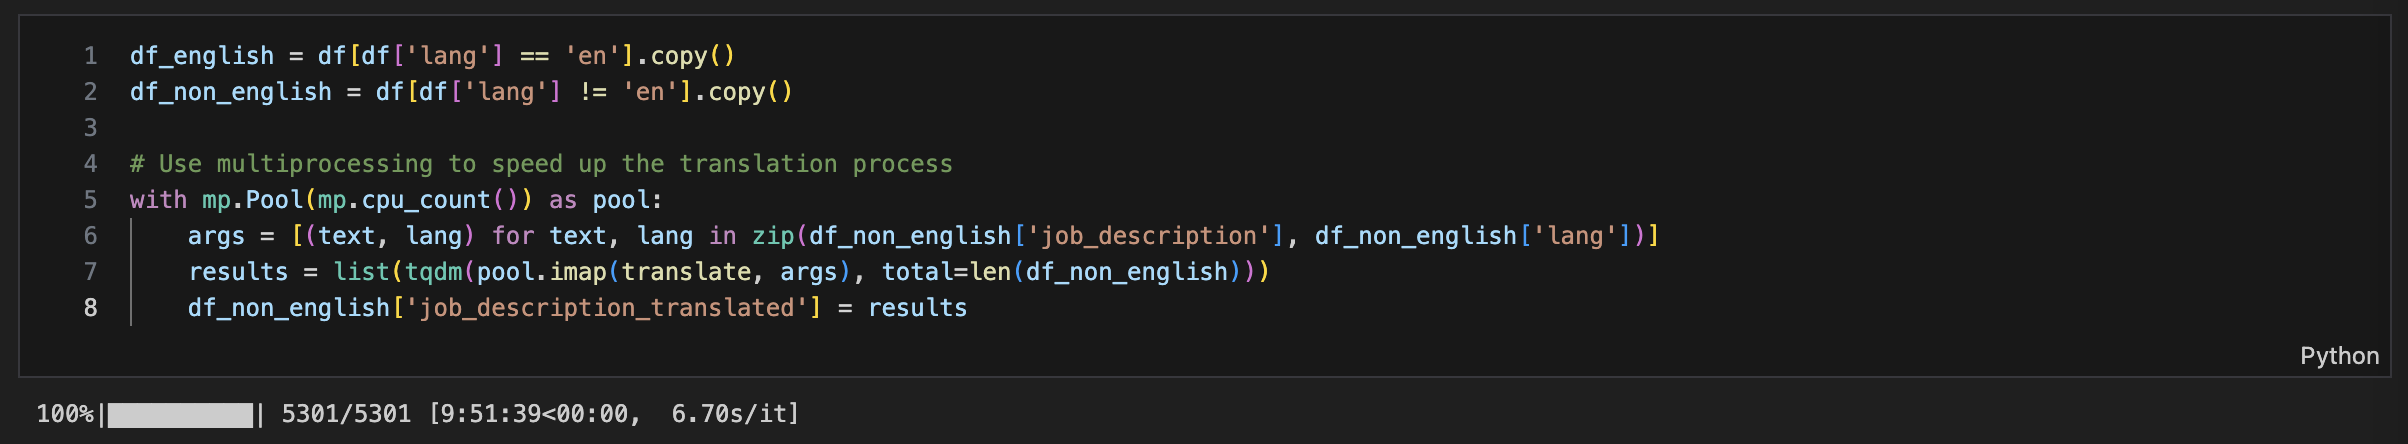

Skip this step if you have already translated the non-English `job_description`s and proceed to the cell reading the `dataset_translated.csv` file.
</div>


In [ ]:
df_english = df[df['lang'] == 'en'].copy()
df_non_english = df[df['lang'] != 'en'].copy()

with mp.Pool(mp.cpu_count()) as pool:
    args = [(text, lang) for text, lang in zip(df_non_english['job_description'], df_non_english['lang'])]
    results = list(tqdm(pool.imap(translate, args), total=len(df_non_english)))
    df_non_english['job_description_translated'] = results


100%|██████████| 5301/5301 [9:51:39<00:00,  6.70s/it]     


In [ ]:
df_english['job_description_translated'] = df_english['job_description']
df = pd.concat([df_english, df_non_english])
df.to_csv('dataset_translated.csv', index=False)

Read the translated dataset.

In [ ]:
df = pd.read_csv('dataset_translated.csv')
df.head(5)

,job_no,job_description,job_type,category,lang,job_description_translated
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en,Zest Scientific is searching for an accomplis...
1,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing,en,Asha Mistry of Umbilical Life is recruiting an...
2,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en,Sales Representative - Laser in der Medizinte...
3,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations,en,Field Service Engineer - Life Science\r\r\r\nC...
4,Id-16692,Due to increased business demand this award w...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en,Due to increased business demand this award w...


In [ ]:
df_unique = df[['job_type','category','lang','job_description_translated']].drop_duplicates()

print(f"Number of unique job descriptions: {len(df_unique)}")   

Number of unique job descriptions: 9444


### Tokenization

For the tokenization process, we used the `nltk` library and some RegEx:
- Remove special characters
- Remove numbers
- Remove characters of length 1 and 2.
- Word tokenizes using nltk's `word_tokenize` function.
- Lemmatize the words using nltk's `WordNetLemmatizer`.
- Translates British English to American English.

In [ ]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

        url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/american_spellings.json"
        self.american_british_dict = requests.get(url).json() 

    def __call__(self, doc):
        doc = re.sub(r'\W+', ' ', doc)
        doc = re.sub(r'\b\w{1,2}\b', '', doc)
        doc = re.sub(r'\d+', '', doc)
  
        words = []
        for t in word_tokenize(doc):
            word = self.wnl.lemmatize(t)
            word = self.american_british_dict.get(word, word)
            words.append(word)
        return words

### Feature Extraction
We used the `TfidfVectorizer` to convert the `job_description` into a matrix of TF-IDF features.

In [ ]:
vectorizer = TfidfVectorizer(
    tokenizer=LemmaTokenizer(),
    stop_words='english',
    strip_accents = 'unicode',
    )
X = vectorizer.fit_transform(df_unique['job_description_translated'])
print("Shape: ", X.shape)
print("Sample features: ", vectorizer.get_feature_names_out()[10:])

/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


Shape:  (9444, 13324)
Sample features:  ['ab' 'abandon' 'abandonment' ... 'zurich' 'zweck' 'zwingend']


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1356321 stored elements and shape (9444, 13324)>

### Dimensionality Reduction

Since we have `13324` features and `9444` samples, we used the `TruncatedSVD` to reduce the dimensionality of the dataset to $N$ features.

Why `TruncatedSVD`?
- Does not require the input data to be mean-centered.
- It is faster than PCA  
- Works with sparse matrices which commonly occurs in TF-IDF matrices.

See how much variance is explained by the first `4000` components

In [ ]:
svd = TruncatedSVD(4000) 
X_svd = svd.fit_transform(X)

# of components to explain 70.0% of variance: 715
# of components to explain 75.0% of variance: 929
# of components to explain 80.0% of variance: 1242
# of components to explain 85.0% of variance: 1768
# of components to explain 88.0% of variance: 2359
# of components to explain 90.0% of variance: 3153


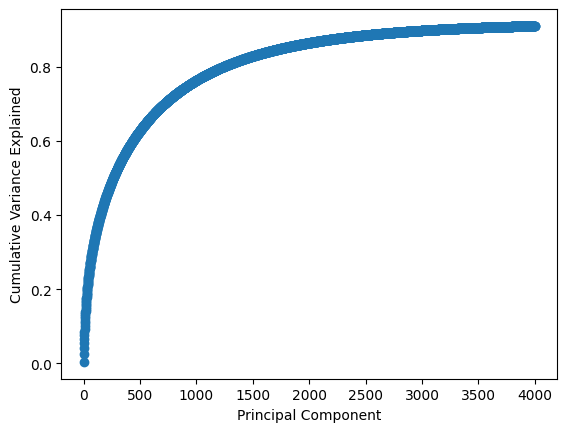

In [ ]:
variance_explained = svd.explained_variance_.cumsum()
plt.plot(range(1, len(variance_explained)+1), variance_explained, 'o-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')

for variance in [0.7,0.75, 0.8, 0.85, 0.88,0.9]:
    print(f"# of components to explain {variance*100}% of variance: {np.argwhere(variance_explained > variance)[0][0]}")

For this project, we used the first `1768` components as it already explains 85% of the variance.

In [ ]:
X_svd = X_svd[:, :np.argwhere(variance_explained > 0.85)[0][0]]
X_svd.shape

(9444, 1500)

### Label Encoding

Transform the categorical labels to numerical values using `LabelEncoder`.

In [ ]:
encoder = LabelEncoder()
df_unique['job_type'] = encoder.fit_transform(df_unique['job_type'])
df_unique['category'] = encoder.fit_transform(df_unique['category'])

y = df_unique[['job_type','category']]
df_unique

,job_type,category,lang,job_description_translated
0,4,6,en,Zest Scientific is searching for an accomplis...
1,1,5,en,Asha Mistry of Umbilical Life is recruiting an...
2,4,6,en,Sales Representative - Laser in der Medizinte...
3,4,2,en,Field Service Engineer - Life Science\r\r\r\nC...
4,4,6,en,Due to increased business demand this award w...
...,...,...,...,...
17650,4,10,es,Veterinary pathologist with scientific respons...
17651,4,9,fr,Experienced medical writing - Germany - Advice...
17652,4,2,fr,QMS specialists - German Switzerland - growing...
17653,4,2,de,"Alcon, United Kingdom\nWould you like to work ..."


<div class="alert alert-info">

## Model Selection and Training
</div>

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_svd, y, test_size=0.25)
# Validation set is already included in the training set

### Define a custom scoring function
Sklearn does not have a native metric to support multiclass multioutput classification [(source)](https://scikit-learn.org/1.5/modules/multiclass.html#multiclass-multioutput-classification).  We created a custom scoring function that computes the F1 score for each class and averages them.

In [ ]:
def f1_multiclass_multioutput(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean([f1_score(y_true[:, i], y_pred[:, i], average='micro') for i in range(y_true.shape[1])])

### Model Selection

Some models support multi-class multi-output classification including most tree-based models, and distanced-based models.  

Meanwhile, some models that do not support multi-class multi-output classification has to be wrapped inside `MultiOutputClassifier`.  This strategy consists of fitting one classifier per target.

For hyperparameter tuning, we used the `GridSearchCV` with the custom scoring function and `n_iter` of 100.

For the cross-validation, we used the `ShuffleSplit` (equivalent to Monte-Carlo CV) with `n_splits=5`.  We used the following models:

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.25) # test size equal to the validation set
param_grid = [
    {
        "clf": [DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreeClassifier(), ExtraTreesClassifier()],
        'clf__max_depth': [10, 30, 50],
        'clf__min_samples_split': [2, 10, 100],
    },
    {
        "clf": [KNeighborsClassifier()],
        'clf__n_neighbors': [5, 10, 100],
        'clf__weights': ['uniform', 'distance'],
    },
    {
        "clf": [MultiOutputClassifier(LogisticRegression())],
        "clf__estimator__penalty": ['l1','l2'],
        "clf__estimator__C": [0.01, 0.1, 1.5, 2.5, 3, 4.5, 6, 7.5, 10],
    },
    {
        "clf": [RadiusNeighborsClassifier()],
        'clf__radius': [1,5,10,15],
        'clf__weights': ['uniform', 'distance'],
    },
    # Removed SVC due to long training times
    # { # 
    #     "clf": [MultiOutputClassifier(SVC())],  
    #     "clf__estimator__C": [0.01, 0.1, 1.4, 10],
    # }
]

steps = [('clf', None)]
pipe = Pipeline(steps)
clf = RandomizedSearchCV(pipe, 
                         param_distributions=param_grid,
                         n_iter=100, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring=make_scorer(f1_multiclass_multioutput), 
                         verbose=2) # ,
clf.fit(x_train, y_train)

Fitting 5 folds for each of 68 candidates, totalling 340 fits


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 68 is smaller than n_iter=100. Running 68 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=10; total time=  35.9s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=2; total time=  36.3s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=2; total time=  36.3s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=10; total time=  36.7s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=2; total time=  36.9s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=2; total time=  37.0s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=2; total time=  37.0s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=10; total time=  37.0s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_samples_split=100; total time=  37.5s
[CV] END clf=DecisionTreeClassifier(), clf__max_depth=10, clf__min_s

/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=2.5, clf__estimator__penalty=l2; total time=  25.9s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=2.5, clf__estimator__penalty=l2; total time=  25.8s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=2.5, clf__estimator__penalty=l2; total time=  26.8s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=4.5, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=4.5, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=4.5, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=4.5, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=4.5, clf__estimator__penalty=l1; total time=   0.1s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=2.5, clf__estimator__penalty=l2; total time=  25.4s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=2.5, clf__estimator__penalty=l2; total time=  25.8s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=3, clf__estimator__penalty=l2; total time=  25.4s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=3, clf__estimator__penalty=l2; total time=  28.4s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=3, clf__estimator__penalty=l2; total time=  27.7s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=6, clf__estimator__penalty=l1; total time=   0.2s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=6, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=6, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=6, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=6, clf__estimator__penalty=l1; total time=   0.1s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=3, clf__estimator__penalty=l2; total time=  26.3s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=3, clf__estimator__penalty=l2; total time=  27.2s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=4.5, clf__estimator__penalty=l2; total time=  28.3s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=4.5, clf__estimator__penalty=l2; total time=  30.2s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=4.5, clf__estimator__penalty=l2; total time=  27.6s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=7.5, clf__estimator__penalty=l1; total time=   0.2s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=7.5, clf__estimator__penalty=l1; total time=   0.1s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=7.5, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=4.5, clf__estimator__penalty=l2; total time=  27.3s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=7.5, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=7.5, clf__estimator__penalty=l1; total time=   0.1s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=4.5, clf__estimator__penalty=l2; total time=  27.6s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=6, clf__estimator__penalty=l2; total time=  28.3s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=6, clf__estimator__penalty=l2; total time=  28.0s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=6, clf__estimator__penalty=l2; total time=  27.7s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=10, clf__estimator__penalty=l1; total time=   0.2s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=10, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=10, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=6, clf__estimator__penalty=l2; total time=  30.1s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=10, clf__estimator__penalty=l1; total time=   0.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=10, clf__estimator__penalty=l1; total time=   0.2s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=7.5, clf__estimator__penalty=l2; total time=  30.0s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=6, clf__estimator__penalty=l2; total time=  31.1s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=7.5, clf__estimator__penalty=l2; total time=  30.0s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=7.5, clf__estimator__penalty=l2; total time=  26.8s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=7.5, clf__estimator__penalty=l2; total time=  29.3s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=uniform; total time=   2.1s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=uniform; total time=   2.0s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=uniform; total time=   1.9s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=uniform; total time=   2.2s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^

[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=7.5, clf__estimator__penalty=l2; total time=  31.1s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=distance; total time=   1.8s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=uniform; total time=   2.1s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_

[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=distance; total time=   2.0s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=distance; total time=   2.2s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=distance; total time=   2.2s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=10, clf__estimator__penalty=l2; total time=  29.3s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=1, clf__weights=distance; total time=   2.5s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_

[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=10, clf__estimator__penalty=l2; total time=  30.3s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=uniform; total time=   4.4s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=uniform; total time=   4.4s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=uniform; total time=   3.3s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=uniform; total time=   3.8s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=uniform; total time=   3.6s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=distance; total time=   2.9s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=distance; total time=   3.2s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=distance; total time=   2.8s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=5, clf__weights=distan

/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=10, clf__estimator__penalty=l2; total time=  34.6s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=15, clf__weights=distance; total time=   3.3s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=15, clf__weights=distance; total time=   3.4s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=15, clf__weights=distance; total time=   3.5s
[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=10, clf__estimator__penalty=l2; total time=  35.1s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[CV] END clf=MultiOutputClassifier(estimator=LogisticRegression()), clf__estimator__C=10, clf__estimator__penalty=l2; total time=  35.2s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=15, clf__weights=distance; total time=   2.0s
[CV] END clf=RadiusNeighborsClassifier(), clf__radius=15, clf__weights=distance; total time=   2.9s


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 340.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/sklearn

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.25, train_size=None),
                   estimator=Pipeline(steps=[('clf', None)]), n_iter=100,
                   n_jobs=-1,
                   param_distributions=[{'clf': [DecisionTreeClassifier(),
                                                 RandomForestClassifier(),
                                                 ExtraTreeClassifier(),
                                                 ExtraTreesClassifier()],
                                         'clf__max_depth': [10, 30, 50],
                                         'clf__min_samples_split': [2, 10,
                                                                    100]},
                                        {'...
                                                          'distance']},
                                        {'clf': [MultiOutputClassifier(estimator=LogisticRegression())],
                                         'clf__estimator__C': [0.01, 0.1, 1.5,
                                                               2.5, 3, 4.5, 6,
                                                               7.5, 10],
                                         'clf__estimator__penalty': ['l1',
                                                                     'l2']},
                                        {'clf': [RadiusNeighborsClassifier()],
                                         'clf__radius': [1, 5, 10, 15],
                                         'clf__weights': ['uniform',
                                                          'distance']}],
                   scoring=make_scorer(f1_multiclass_multioutput, response_method='predict'),
                   verbose=2)

<div class="alert alert-info">

## Model Evaluation
</div>

In [ ]:
results = pd.DataFrame(clf.cv_results_)
results = results[['rank_test_score','param_clf','mean_test_score','mean_fit_time','mean_score_time','params']].sort_values(by='rank_test_score')
results.head(20)

,rank_test_score,param_clf,mean_test_score,mean_fit_time,mean_score_time,params
47,1,MultiOutputClassifier(estimator=LogisticRegres...,0.711406,22.729915,0.121570,"{'clf__estimator__penalty': 'l2', 'clf__estima..."
49,2,MultiOutputClassifier(estimator=LogisticRegres...,0.711180,25.822392,0.112199,"{'clf__estimator__penalty': 'l2', 'clf__estima..."
51,3,MultiOutputClassifier(estimator=LogisticRegres...,0.710954,26.880476,0.146474,"{'clf__estimator__penalty': 'l2', 'clf__estima..."
53,4,MultiOutputClassifier(estimator=LogisticRegres...,0.708922,28.053749,0.132705,"{'clf__estimator__penalty': 'l2', 'clf__estima..."
55,5,MultiOutputClassifier(estimator=LogisticRegres...,0.706437,28.908930,0.114777,"{'clf__estimator__penalty': 'l2', 'clf__estima..."
57,6,MultiOutputClassifier(estimator=LogisticRegres...,0.705590,29.317460,0.119695,"{'clf__estimator__penalty': 'l2', 'clf__estima..."
59,7,MultiOutputClassifier(estimator=LogisticRegres...,0.704856,32.714028,0.187811,"{'clf__estimator__penalty': 'l2', 'clf__estima..."
38,8,KNeighborsClassifier(),0.698363,0.203023,2.635089,"{'clf__weights': 'uniform', 'clf__n_neighbors'..."
36,9,KNeighborsClassifier(),0.695031,0.154735,1.612135,"{'clf__weights': 'uniform', 'clf__n_neighbors'..."
37,10,KNeighborsClassifier(),0.683569,0.151678,1.674610,"{'clf__weights': 'distance', 'clf__n_neighbors..."


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'MultiOutputClassifier(estimator=LogisticRegression())'),
  Text(1, 0, 'KNeighborsClassifier()'),
  Text(2, 0, 'DecisionTreeClassifier()'),
  Text(3, 0, 'RandomForestClassifier()'),
  Text(4, 0, 'ExtraTreesClassifier()'),
  Text(5, 0, 'ExtraTreeClassifier()'),
  Text(6, 0, 'RadiusNeighborsClassifier()')])

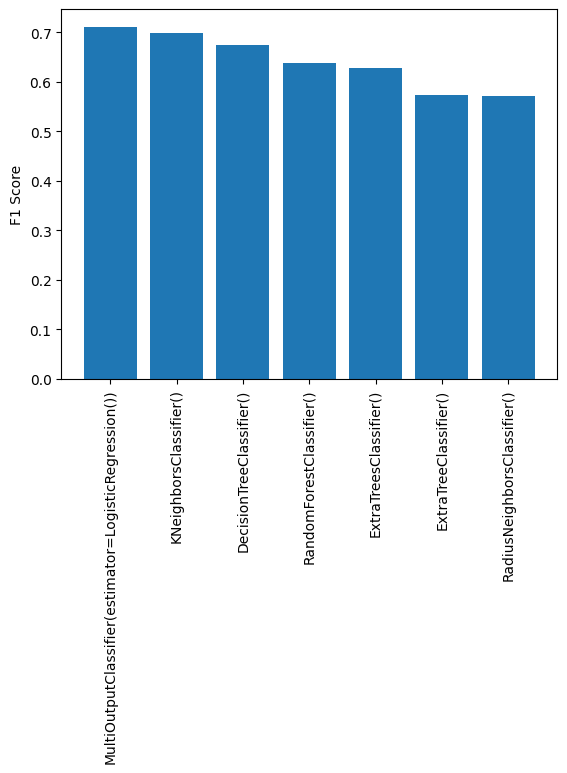

In [ ]:
results["param_clf_str"] = results["param_clf"].astype(str)
idx = results.groupby("param_clf_str")["mean_test_score"].idxmax()
max_results = results.loc[idx, ["param_clf_str","mean_test_score", "rank_test_score", "params"]].sort_values("mean_test_score", ascending=False)

plt.bar(max_results["param_clf_str"], max_results["mean_test_score"])
plt.ylabel("F1 Score")
plt.xticks(rotation=90)

In [ ]:
clf.best_estimator_.get_params()

{'memory': None,
 'steps': [('clf',
   MultiOutputClassifier(estimator=LogisticRegression(C=1.5)))],
 'verbose': False,
 'clf': MultiOutputClassifier(estimator=LogisticRegression(C=1.5)),
 'clf__estimator__C': 1.5,
 'clf__estimator__class_weight': None,
 'clf__estimator__dual': False,
 'clf__estimator__fit_intercept': True,
 'clf__estimator__intercept_scaling': 1,
 'clf__estimator__l1_ratio': None,
 'clf__estimator__max_iter': 100,
 'clf__estimator__multi_class': 'deprecated',
 'clf__estimator__n_jobs': None,
 'clf__estimator__penalty': 'l2',
 'clf__estimator__random_state': None,
 'clf__estimator__solver': 'lbfgs',
 'clf__estimator__tol': 0.0001,
 'clf__estimator__verbose': 0,
 'clf__estimator__warm_start': False,
 'clf__estimator': LogisticRegression(C=1.5),
 'clf__n_jobs': None}

In [ ]:
score = clf.score(x_test, y_test)
print("Best model's score on the test dataset: ", score)

Best model's score on the test dataset:  0.7172808132147395


## Results and Discussion
Sample Text Here


## Conclusion
Sample Text Here